In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/txt-file/train.txt
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


### github url:
Github link: https://github.com/carsonxie/Machine-Learning-Projects/tree/main/c3%20--%20Deep%20Learning%20Method


install dependency of the preprocessing for BERT inputs

In [2]:
pip install -q -U "tensorflow-text==2.8.*"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tfx-bsl 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tfx-bsl 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tensorflow-transform 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tensorflow-transform 1.5.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,<2.8,>=1.15.2, but you have tensorflow 2.8.0 which is incompat

In [3]:
#pip install -q tf-models-official==2.7.0

In [4]:
import pandas as pd
import os
import numpy as np
import pandas as pd
import zipfile
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import datetime
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
#import tensorflow_addons as tfa
#from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')
%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

# dataset from 
# https://www.kaggle.com/competitions/quora-insincere-questions-classification

## Notebook outline: 
### 1. Preprocessing the data
### 2. Data visulization
### 2. Load Bert model
### 3. Train
### 4. Evaluate and Conlusion

#### Create dataset

In [5]:
from sklearn.model_selection import train_test_split

train_df =  pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
# shape (1306122, 3)
train_df = train_df.drop(['qid'],axis=1)
#train_df = train_df.sample(50000)
train = train_df.iloc[:100000].sample(30000)
test = train_df.iloc[100000:].sample(3000)


In [6]:
import string
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

In [7]:
train['question_text'] = train['question_text'].apply(lambda x: x.lower())
train['question_text'] = train['question_text'].apply(lambda x : remove_punct(x))

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train['question_text'], 
                                                  train['target'],
                                                  test_size = 0.2, random_state=42)

# train_lines, train_labels = train.question_text.values, train.target.values
# test_lines, test_labels = test.question_text.values, test.target.values
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(test.shape)

(24000,)
(24000,)
(6000,)
(6000,)
(3000, 2)


In [9]:
train.tail()

,question_text,target
65033,how can i grow more neurons in my brain,0
94218,if my son gets a full ride to all ivy leagues ...,1
26869,what is the minimum amount of words i need to ...,0
60262,is america hypocritical to get mad about their...,0
25530,does vodafone have volte service active in del...,0


### EDA

0    1225312
1      80810
Name: target, dtype: int64
Class 0 are 1416.3 % more than class 1


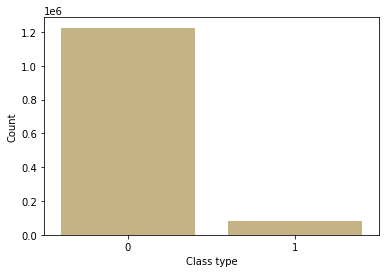

In [10]:
#cnt_srs = train_df['target'].value_counts()
count = train_df['target'].value_counts()
sns.barplot(x=count.index, y=count, color='#CFB87C')
print(count)
plt.ylabel("Count")
plt.xlabel("Class type")
print('Class 0 are', 100*round((count[0]-count[1])/count[1],3), '% more than class 1')

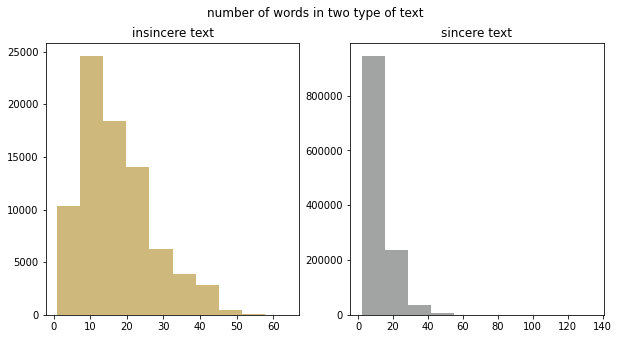

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = train_df[train_df['target']==1]['question_text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='#CFB87C')
ax1.set_title('insincere text')
tweet_len = train_df[train_df['target']==0]['question_text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#A2A4A3')
ax2.set_title('sincere text')
fig.suptitle('number of words in two type of text')
plt.show()

### Word cloud
(https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-qiqc)

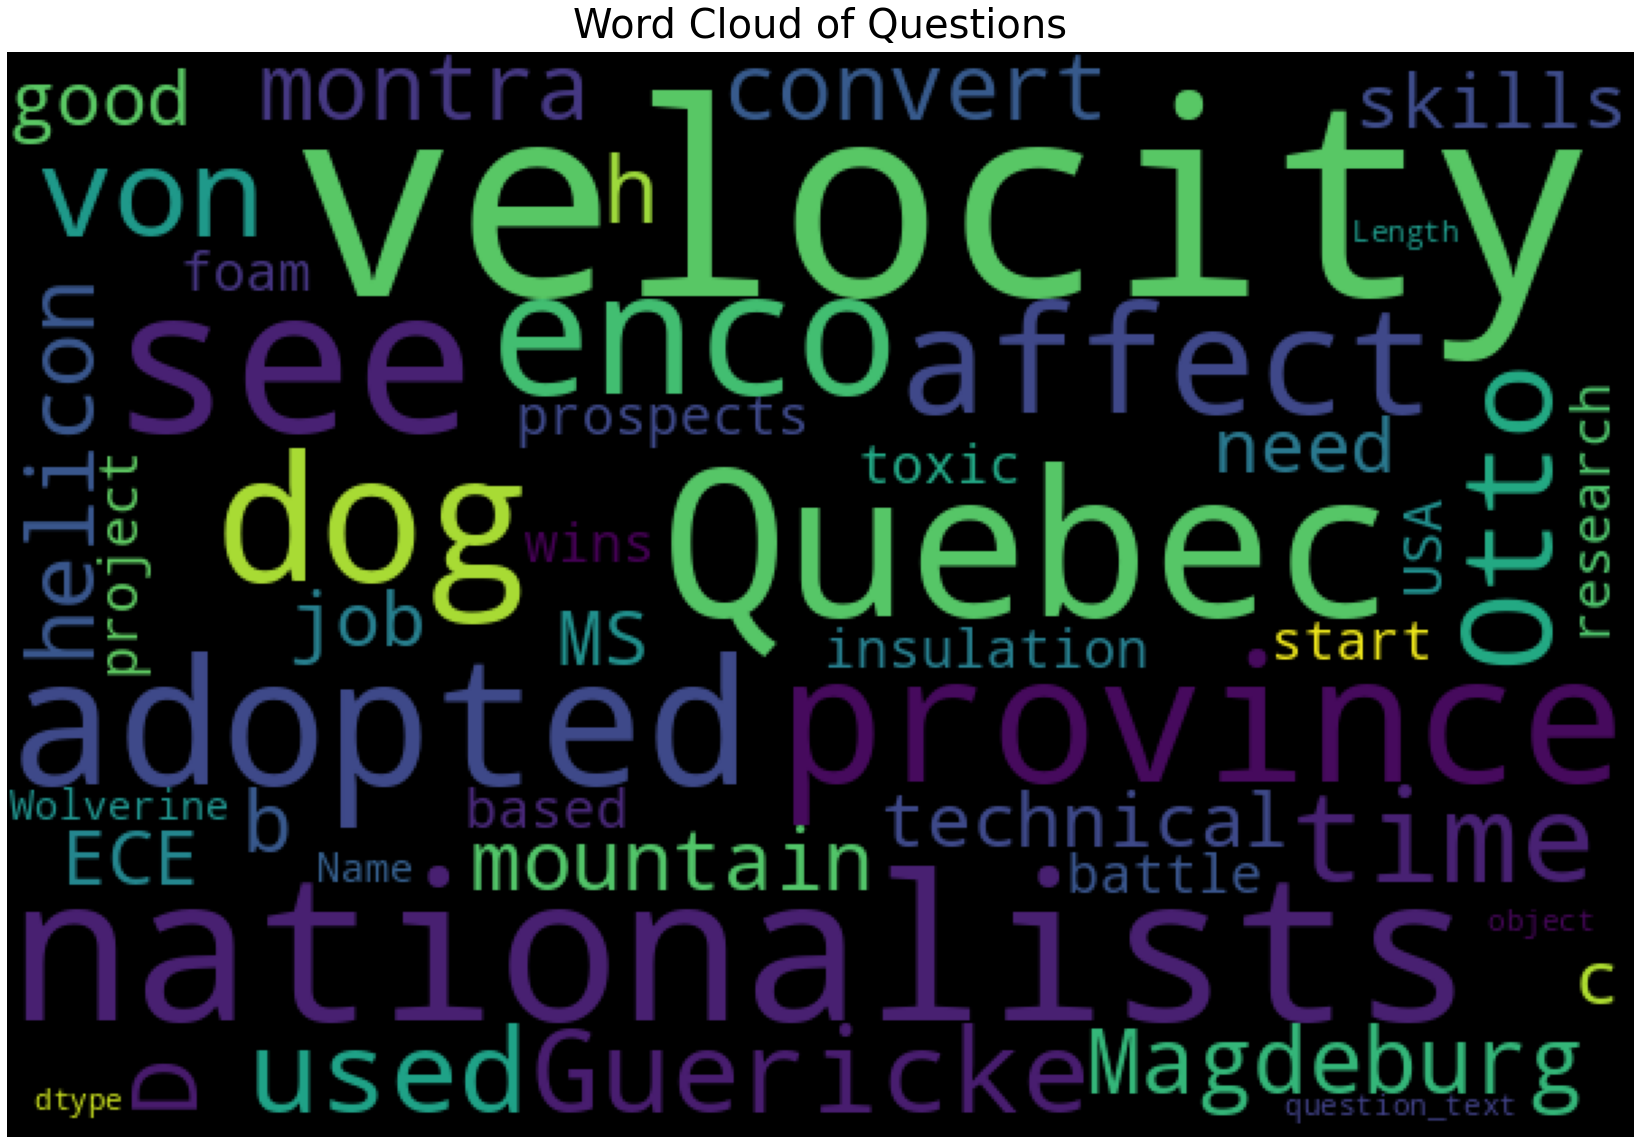

In [12]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=600, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["question_text"], title="Word Cloud of Questions")

### Bi-gram count 
(https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-qiqc)

In [13]:
from collections import defaultdict
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [14]:
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')



freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

/opt/conda/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Load bert model

In [15]:
#load model

#bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12' 

#bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-256_A-4'

#bert_model_name = 'small_bert/bert_en_uncased_L-2_H-512_A-8'

map_name_to_handle = {
'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'}

map_model_to_preprocess = {
'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### The preprocessing model

- bert preprocess layer
- bert encoder layer
- dense layer
- dropout

In [16]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

bert_model = hub.KerasLayer(tfhub_handle_encoder)

2022-04-20 14:50:50.452040: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-20 14:50:50.463250: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


example output

In [17]:
text_test = ['this is such an amazing movie!']
#text_test= [X_train[0]]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Pooled Outputs Shape:(1, 256)
Pooled Outputs Values:[ 0.9923972  -0.05357222  0.30918548  0.95055723 -0.05440636  0.9988622
 -0.9947893  -0.00854004 -0.45510456 -0.08636695  0.8320393  -0.9255265 ]
Sequence Outputs Shape:(1, 128, 256)
Sequence Outputs Values:[[-0.96845514 -1.7037109   1.0094739  ...  0.84075063  0.35471374
  -1.8288113 ]
 [-0.73150206 -0.91066974  0.30870232 ...  1.2626395   0.18190722
  -0.87057996]
 [-1.115116   -1.8587099   1.9688952  ...  0.474723    1.1492233
  -0.36351842]
 ...
 [-1.0249408  -1.7695187   0.3631691  ...  0.35074988  0.1835608
  -0.676558  ]
 [-0.4708272  -2.05066     0.2558358  ...  0.85013616  0.18506251
  -0.6660274 ]
 [-0.14080226 -1.8676224   0.6415795  ...  0.25832358  0.04616908
  -0.14218277]]


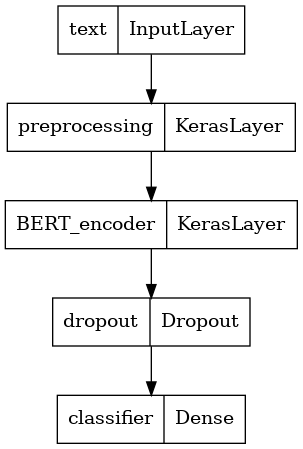

In [19]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

model = build_classifier_model()
tf.keras.utils.plot_model(model)

In [20]:
# # %%time
# bert_raw_result = model(tf.constant(text_test))
# print(bert_raw_result)

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) #'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5,epsilon=1e-8,clipnorm=1.0)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=METRICS)

In [22]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=5)

Epoch 1/5
750/750 [==============================] - 713s 945ms/step - loss: 0.1596 - accuracy: 0.9438 - precision: 0.6459 - recall: 0.2644 - val_loss: 0.1239 - val_accuracy: 0.9523 - val_precision: 0.5756 - val_recall: 0.5858
Epoch 2/5
750/750 [==============================] - 709s 945ms/step - loss: 0.1256 - accuracy: 0.9499 - precision: 0.6577 - recall: 0.4491 - val_loss: 0.1154 - val_accuracy: 0.9562 - val_precision: 0.6354 - val_recall: 0.5207
Epoch 3/5
750/750 [==============================] - 714s 952ms/step - loss: 0.1081 - accuracy: 0.9572 - precision: 0.7106 - recall: 0.5561 - val_loss: 0.1194 - val_accuracy: 0.9567 - val_precision: 0.6413 - val_recall: 0.5237
Epoch 4/5
750/750 [==============================] - 721s 961ms/step - loss: 0.0949 - accuracy: 0.9625 - precision: 0.7427 - recall: 0.6312 - val_loss: 0.1243 - val_accuracy: 0.9577 - val_precision: 0.6780 - val_recall: 0.4734
Epoch 5/5
750/750 [==============================] - 729s 972ms/step - loss: 0.0771 - accura

In [23]:
model.evaluate(test['question_text'].values, test['target'].values)

94/94 [==============================] - 22s 228ms/step - loss: 0.1495 - accuracy: 0.9317 - precision: 0.4751 - recall: 0.6458


[0.14953087270259857,
 0.9316666722297668,
 0.4750957787036896,
 0.6458333134651184]

In [24]:
y_predicted = model.predict(test['question_text'].values)
y_predicted = y_predicted.flatten()

y_predicted = np.where(y_predicted > 0.5, 1, 0)

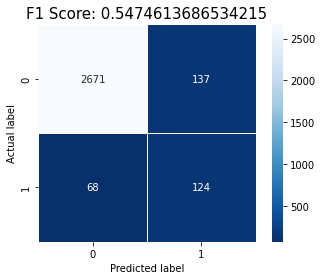

In [25]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score
import seaborn as sns


cfm = confusion_matrix(test['target'].values, y_predicted)
f1 = f1_score(test['target'].values, y_predicted)
sns.heatmap(cfm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'F1 Score: {0}'.format(f1)
plt.title(all_sample_title, size = 15);

## Reference：
https://www.kaggle.com/code/sergeykalutsky/introducing-bert-with-tensorflow/notebook

https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/157801

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/47_BERT_text_classification/BERT_email_classification-handle-imbalance.ipynb

bert paper: https://arxiv.org/pdf/1810.04805.pdf

https://www.kaggle.com/code/theoviel/improve-your-score-with-some-text-preprocessing